In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import math

# Step 1: Generate the data 
I'm aiming to generate 20000 datapoints from a Gaussian mixture model of k = 100 components. For simplicity, each datapoint is a scalar (1-dimension). 
To make it more realistic, I will random the weight of each component.

In [24]:
n = 20000 # Number of datapoints
k = 100 # Number of components

# Randomising the weights
weights = np.random.random(size=(k, ))
weights = weights / np.sum(weights) 
assert abs(np.sum(weights) - 1) < 0.00001

# Decide which component we will sample from
mixture_index = np.random.choice(k, size = n, replace = True, p = weights)
assert mixture_index.shape == (n, )

# Decide the random mean and variance of all 100 components
mean = np.random.uniform(low=-20.0, high=20.0, size=(k, ))
variance = np.random.uniform(low=0, high=3.0, size=(k, ))


In [27]:
# Generate data using numpy for efficiency
data = np.fromiter((np.random.normal(loc = mean[index], scale = np.sqrt([variance[index]])[0]) for index in mixture_index), float)
assert data.shape == (n, )

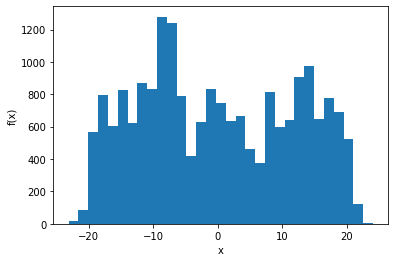

In [29]:
plt.hist(data, bins="auto")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Step 2: The traditional EM algorithm
The algorithm includes finding the probability of each point belonging to each component, then tune the mean and variance of each component according the the calculated probabilities. 

In [38]:
# First, define a way to calculate pdf 
def pdf(x, mean, var):
    assert var >= 0
    return math.exp(-0.5 * (((float(x) - float(mean))) ** 2 ) / var) / (math.sqrt(2 * math.pi * var))

# Test the function
assert pdf(0, 0, 1) == 0.3989422804014327
assert pdf(0.5, 0, 1) == 0.3520653267642995


In [45]:
# This implementation is inspired by Dr. Martha White's notes for CMPUT367, page 107. 
def traditional_EM():
    predicted_mean = np.random.random(k)
    predicted_variance = np.random.random(k)
    predicted_weights = np.ones(k) / k
    
    error = np.linalg.norm(mean - predicted_mean, 2)
    error += np.linalg.norm(variance - predicted_variance, 2)
    error += np.linalg.norm(weights - predicted_weights, 2)
    
    while error >= 8628370181.169346:
        probability_matrix = np.zeros((n, k))
        normalised_p_matrix = np.zeros((n, k))
        for i in range(n):
            denominator_sum = 0
            for j in range(k):
                probability_matrix[i, j] = predicted_weights[j] * pdf(data[i], predicted_mean[j], predicted_variance[j])
                denominator_sum += probability_matrix[i, j]
            probability_matrix[i, :] = probability_matrix[i, :] / denominator_sum
         
            normalised_p_matrix[i, :] = probability_matrix[i, :] / np.sum(probability_matrix[i, :])
            
        for j in range(k):
            predicted_weights[j] = float(1/n) * np.sum(probability_matrix[:, j])
            predicted_mean[j] = np.sum(normalised_p_matrix[:, j] * data)
            predicted_variance[j] = np.sum(normalised_p_matrix[:, j] * (np.linalg.norm(data - predicted_mean[j], 2)) ** 2)
        
        error = np.linalg.norm(mean - predicted_mean, 2)
        error += np.linalg.norm(variance - predicted_variance, 2)
        error += np.linalg.norm(weights - predicted_weights, 2)
        
        print("error:", error)
    return predicted_mean, predicted_variance, predicted_weights


predicted_mean, predicted_variance, predicted_weights = traditional_EM()
print(predicted_mean, predicted_variance, predicted_weights)

[0.27414015 0.23400901 0.36560499 0.3673932  0.51237975 0.40885679
 0.72760286 0.40553564 0.8906912  0.08686441 0.49889843 0.49140418
 0.17799974 0.43506238 0.0200561  0.04866437 0.42931182 0.29955814
 0.03012795 0.17478946 0.21246087 0.80462723 0.44156527 0.35777876
 0.87126827 0.78816174 0.87292638 0.81110704 0.04290283 0.87335029
 0.99310686 0.93780679 0.96140308 0.39457965 0.24086012 0.78093334
 0.85422282 0.30611113 0.63325345 0.96967908 0.78711162 0.57430174
 0.09229893 0.78672782 0.42240235 0.30288648 0.87707859 0.4215961
 0.9595822  0.11148371 0.05095562 0.98732811 0.67286103 0.44107044
 0.81993555 0.21404758 0.13489028 0.3489893  0.30723238 0.73753973
 0.28393179 0.50455115 0.50857222 0.32703714 0.02054651 0.7377169
 0.31378317 0.31716955 0.2505203  0.29689135 0.31350865 0.02172159
 0.30189098 0.9342512  0.47098591 0.24231545 0.24252971 0.28844763
 0.5909655  0.23892156 0.47621666 0.00783082 0.41258015 0.37865945
 0.5385957  0.87574337 0.57793106 0.07024516 0.03812031 0.230765